Goal: create circular maps

In [165]:
import osmnx as ox
import geopandas as gpd
import contextily as cx
import shapely as shp
import matplotlib.pyplot as plt

In [166]:
# PLACE_NAMES = [
#     # "Marikina, Metro Manila",
#     # "Quezon City, Metro Manila",
#     # "Manila, Metro Manila",
#     "Pasig, Metro Manila",
#     # "Taguig, Metro Manila"
# ]

In [167]:
# Set name for Nominatim query
query = "Cagayan de Oro"

In [168]:
# Geocode point from place name
place = ox.geocode(query)
place

(8.4756417, 124.6421532)

In [169]:
# Parse place name out of query (if necessary)
place_name = query.split(", ")[0] if "," in query else query
place_name

'Cagayan de Oro'

In [170]:
# Create geodataframe from geocoded point
# later to be buffered
buffer = gpd.GeoDataFrame(
    {
        "name": [place_name],
        # Reverse coordinate tuple first...
        # because coordinates = (lat, lon),
        # but shapely.Point tuple = (x, y)
        "geometry": shp.Point(reversed(place))
    },
    crs="EPSG:4326"
)
buffer.head()

,name,geometry
0,Cagayan de Oro,POINT (124.64215 8.47564)


<Axes: >

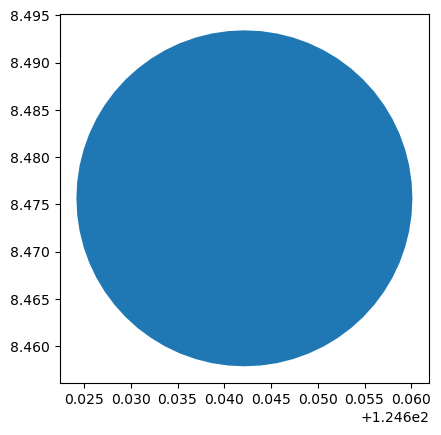

In [171]:
# Set buffer distance in meters
buffer_dist=2_000

# Reproject to pseudo-mercator first...
buffer = buffer.to_crs("EPSG:3857")

# ...so that CRS units are in meters
buffer["geometry"] = buffer["geometry"].buffer(buffer_dist)

# Reproject back to WGS 84 (for OSMnx)
buffer = buffer.to_crs("EPSG:4326")

buffer.plot()

In [172]:
# Get road network within buffer
graph = ox.graph_from_polygon(buffer.geometry[0])

# Convert intersections and streets to geodataframe
intersections, streets = ox.graph_to_gdfs(graph)

In [173]:
# Reproject both GDFs to pseudo-mercator
streets = streets.to_crs("EPSG:3857")
intersections = intersections.to_crs("EPSG:3857")

In [174]:
# Set all NaN values in lanes column to 1
streets.loc[streets["lanes"].isna(), "lanes"] = 1

# set all list values in lanes column to maximum item in list
streets["lanes"] = streets["lanes"].apply(
    lambda x: max(x) if isinstance(x, list) == True else x
)

# Convert lanes column to type int
streets["lanes"] = streets["lanes"].astype(int)

In [175]:
# Get min and max number of lanes
min_lanes = streets["lanes"].min()
max_lanes = streets["lanes"].max()

# Assign line width per number of lanes
linewidths = {lane: lane * 0.25 for lane in range(min_lanes, max_lanes + 1)}
linewidths

{1: 0.25, 2: 0.5, 3: 0.75, 4: 1.0}

([], [])

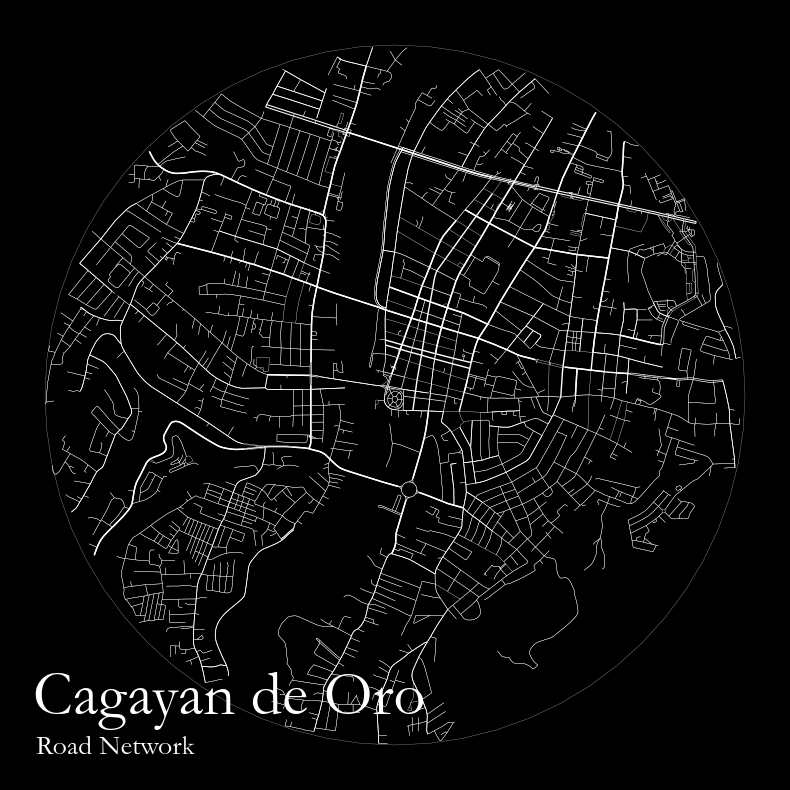

In [202]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10,10))

# For each lane number in streets...
for lane, data in streets.groupby("lanes"):
    # Plot all streets with x no. of lanes...
    data.plot(
        color="white",
        ax=ax,
        label=lane,
        linewidth=linewidths[lane] # with correct line width
    )

# Set axis properties
ax.set_facecolor("black")
ax.set_title(
    # f"{place_name}\nRoad Network",
    place_name,
    loc="left",
    color="white",

    fontsize=45.0,
    fontfamily="Garamond",
    fontstretch="expanded",

    y=0.08, # 5% of figure height (from bottom)
    x=0.03, # 95% of figure width (from left)
    pad=3.0
)
ax.text(
    x=minx-50,
    y=miny-50,
    s="Road Network",
    color="white",
    fontsize=20.0,
    fontfamily="Garamond",
    fontstretch="expanded"
)

buffer.to_crs("EPSG:3857").plot(
    edgecolor="darkgrey",
    facecolor="none",
    linewidth=0.25,
    ax=ax
)

fig.set_facecolor("black")
fig.set_edgecolor("black")

# fig.suptitle(
#     f"Road Network",
#     ha="left",
#     color="white",

#     fontsize=24.0,
#     fontfamily="Garamond",
#     fontstretch="expanded",

#     y=0.03, # 5% of figure height (from bottom)
#     x=0.03, # 95% of figure width (from left)
#     # pad=3.0
# )

# Get bounding box of buffer circle...
minx, miny, maxx, maxy = buffer.to_crs("EPSG:3857").total_bounds

# ...to set x- and y-limits of axes (to ensure it is a square)
ax.set_xlim(left=minx - 200, right=maxx + 200)
ax.set_ylim(bottom=miny - 200, top=maxy + 200)

# # Set legend properties
# legend = ax.legend(
#     title="Number of lanes",
#     prop={"family":"Garamond"},
#     title_fontproperties={
#         "family":"Garamond",
#         "size": 14.0
#     },
#     loc=(0.05, 0.70),
#     facecolor="black",
#     labelcolor="white",
    
#     frameon=False,
#     reverse=True,
#     alignment="left",

#     borderpad=1.0,
#     labelspacing=0.75
# )
# plt.setp(legend.get_title(), color="white")

# Remove axis labels for photo finish
plt.xticks([])
plt.yticks([])

# # Remove margins?
# plt.tight_layout(pad=7)